# Imports

In [932]:
from numpyNN import *
import numpy as np
import matplotlib.pyplot as plt

# Dataset

Text(0.5, 1.0, 'Example Data - linear-separable Dataset')

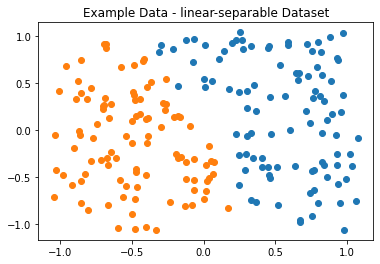

In [933]:
x_train, y_train, x_test, y_test = sample_data(data_name='linear-separable', nTrain=200, nTest=200, random_seed=0)

class_0 = np.where(y_train == 0)
class_1 = np.where(y_train == 1)

x_train_0 = x_train[class_0[0], :]
x_train_1 = x_train[class_1[0], :]
y_train_0 = np.where(y_train == 0)
y_train_1 = np.where(y_train == 1)

plt.scatter(x_train_0[:,0], x_train_0[:,1], label='0')
plt.scatter(x_train_1[:,0], x_train_1[:,1], label='1')
plt.title('Example Data - linear-separable Dataset')

# Prepare Classes for Activation Functions

In [934]:
class linear:
    def forward(self, Z):
        self.A = Z
        return self.A
    
    def backward(self):
        dAdZ = np.ones(self.A.shape, dtype="f")
        return dAdZ


class sigmoid:
    def forward(self, Z):
        self.A = 1/(1+np.exp(-Z)) 
        return self.A
    
    def backward(self):
        dAdZ = self.A-self.A**2 
        return dAdZ


class tanh:
    def forward(self, Z):
        self.A = np.tanh(Z)
        return self.A
    
    def backward(self):
        dAdZ = 1-self.A**2
        return dAdZ


class ReLU:
    def forward(self, Z):
        self.A = np.maximum(0, Z)
        return self.A
    
    def backward(self):
        dAdZ = (np.array(self.A > np.zeros_like(self.A))).astype(float)
        return dAdZ

# Prepare Classes for Loss Functions

In [935]:
# L2 Loss:
class L2_loss:
  def forward(self, A, y):
    # print(A)
    self.A = A
    self.y = y
    # print('here: ', self.A)
    self.error = np.mean(((A-y)**2))
    return self.error
  
  def backward(self):
    dLdA = self.A - self.y
    return dLdA

# Cross entrpy loss:
class cross_entropy:
  def forward(self, y_pred, y_true):

    self.y_pred = y_pred
    self.y_true = y_true
    self.loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return self.loss
    # return self.error
  
  def backward(self):
    # dLdA = self.error-self.y

    self.grad = (self.y_pred - self.y_true) / (self.y_pred * (1 - self.y_pred))

    return self.grad
    # return dLdA

# Optimization/Update

In [936]:
# Basic Gradient Descent
class BGD:
  def __init__(self, MLP):
      self.MLP = MLP

  def update(self, W, b, lr, momentum = 0):
    W_new = []
    b_new = []
    for ii in range(len(W)):
      W_new.append(W[ii] - lr*np.array(self.MLP.dLdW[ii]))
      b_new.append(b[ii] - lr*np.array(self.MLP.dLdb[ii]))
    self.MLP.W = W_new
    self.MLP.b = b_new

# Gradient Descent with Momentum
class GDM:
  def __init__(self, MLP, momentum = 0):
    self.Vw = []
    self.Vb = []
    self.momentum = momentum 
    for ii in range(len(MLP.W)):
      self.Vw.append(np.zeros_like(MLP.W[ii]))
      self.Vb.append(np.zeros_like(MLP.b[ii]))

    self.MLP = MLP

  def update(self, W, b,  lr):
    mu = self.momentum
    W_new = []
    b_new = []
    for ii in range(len(self.MLP.W)):
      self.Vw[ii] = mu*self.Vw[ii] + self.MLP.dLdW[ii]
      self.Vb[ii] = mu*self.Vb[ii] + self.MLP.dLdb[ii]

      W_new.append(W[ii] - lr*self.Vw[ii])
      b_new.append(b[ii] - lr*self.Vb[ii])

    self.MLP.W = W_new
    self.MLP.b = b_new

class Adam:

    def __init__(self, MLP, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        
        # def __init__(self, MLP)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w = None
        self.v_w = None
        self.m_b = None
        self.v_b = None
        self.t = 0
        self.MLP = MLP

    def update(self, weights, biases, learning_rate=0.001, momentum=0):
      # update(self, W, b, lr, momentum = 0, beta1=0.9, beta2=0.99, e = 0.1)
        grad_weights = self.MLP.dLdW
        grad_biases = self.MLP.dLdb
        if self.m_w is None:
            self.m_w = [np.zeros_like(w) for w in weights]
            self.v_w = [np.zeros_like(w) for w in weights]
            self.m_b = [np.zeros_like(b) for b in biases]
            self.v_b = [np.zeros_like(b) for b in biases]

        self.t += 1
        learning_rate_t = self.learning_rate * np.sqrt(1 - self.beta2 ** self.t) / (1 - self.beta1 ** self.t)

        for i in range(len(weights)):
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * grad_weights[i]
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * grad_weights[i] ** 2
            weights[i] -= learning_rate_t * self.m_w[i] / (np.sqrt(self.v_w[i]) + self.epsilon)

        for i in range(len(biases)):
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grad_biases[i]
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * grad_biases[i] ** 2
            biases[i] -= learning_rate_t * self.m_b[i] / (np.sqrt(self.v_b[i]) + self.epsilon)


# Initialize & Create MLP

In [937]:
class MLP:
  def __init__(self, num_layers, num_width , opt_act, loss = 'L2', out_size = 1):
    '''
    Parameters:
    1- num_layers : scalar - number of layers including input and output layers
    2- num_width  : list of scalar - number of neurons in each layer (don't forget input and output layer)
    3- opt_act    : list of str - activation functions (ReLU, sigmoid, tanh, or linear)
    4- loss       : str - loss function (L2, or cross_entropy)
    '''
    # Check settings if correct and set widths:
    assert(num_layers == len(num_width)) # check whether the size of widths is same as the number of layers
    assert(num_layers-1 == len(opt_act)) # check whether the size of activation option of each layer is same as the number of layers
    # if loss == 'cross_entropy' and opt_act[-1] != 'linear':
    #   print('Last layer activation must be "linear"')
    #   assert(0==1)
    
    self.num_layers = num_layers

    #### initialize Weights
    self.W = [] # initialize list of weights
    for ii in range(1,num_layers):
      low = -np.sqrt(6/(num_width[ii-1]+num_width[ii]))
      high = -low
      self.W.append(np.random.uniform(low, high, size=(num_width[ii],num_width[ii-1])))

    #### Initialize bias
    self.b = []
    for ii in range(1,num_layers):
      low = -np.sqrt(6/(num_width[ii]))
      high = -low
      b = np.random.uniform(low, high, size = (num_width[ii],1)).reshape(-1,1)
      self.b.append(b)

    #### Activations
    self.activation = []
    for ii, act_option in enumerate(opt_act):
      if act_option == 'linear':
        self.activation.append(linear())
      elif act_option == 'ReLU':
        self.activation.append(ReLU())
      elif act_option == 'sigmoid':
        self.activation.append(sigmoid())
      elif act_option == 'tanh':
        self.activation.append(tanh())
      else:
        print('You choose an invalid activation!')
      
    #### Set desired loss fuction
    if loss == 'L2':
      self.err = L2_loss()
    elif loss == 'cross_entropy':
      self.err = cross_entropy()

    #### Forward
  def forward(self, x):
    self.A = []
    self.A.append(x)
    for ii in range(len(self.W)):
      self.Ones = np.ones((self.A[ii].shape[0],1), dtype="f")
      self.b[ii] = self.b[ii].reshape(-1,1)
      # print('b shape: ', self.b[ii].shape)
      # Z = np.dot(self.A[ii], self.W[ii].T) + self.b[ii]
      Z = np.matmul(self.A[ii], np.transpose(self.W[ii])) + np.matmul(self.Ones,np.transpose(self.b[ii]))
      self.A.append(self.activation[ii].forward(Z))
    return self.A[-1]
  
    #### Loss
  def mlploss(self, y_pred, y_train):
    # print('here: ', y_pred)
    self.loss = self.err.forward(y_pred, y_train)
    self.dLdA = self.err.backward()
    return self.loss

    
    #### Backward
  def backward(self):
    self.dLdW = [0]*(self.num_layers-1)
    self.dLdb = [0]*(self.num_layers-1)
    dLdA = self.dLdA

    for ii in reversed(range(self.num_layers-1)):
      # print('ii: ', ii)
      dLdz = dLdA*self.activation[ii].backward()
      dzdW = self.A[ii].T
      dzdb = self.Ones

      self.dLdW[ii] = (np.matmul(dzdW, dLdz))
      # print('dLdW', self.dLdW[ii].shape)

      self.dLdb[ii] = (np.matmul(dLdz.T, dzdb))
      # print('dLdb', self.dLdb[ii].shape)

      dzdA = self.W[ii].T
      # print('dzdA: ', dzdA.shape)

      dLdA = np.matmul(dLdz, dzdA.T)
    
    for ii in range(self.num_layers-1):
      self.dLdW[ii] = self.dLdW[ii].T
      self.dLdb[ii] = self.dLdb[ii]


# Linear separable dataset

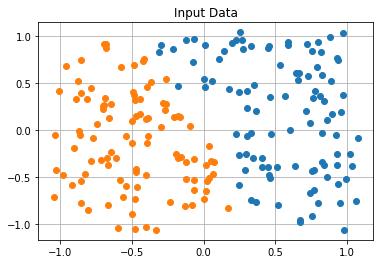

In [938]:
x_train, y_train, x_test, y_test = sample_data(data_name='linear-separable', nTrain=200, nTest=200, random_seed=0)

class_0 = np.where(y_train == 0)
class_1 = np.where(y_train == 1)

x_train_0 = x_train[class_0[0], :]
x_train_1 = x_train[class_1[0], :]
y_train_0 = np.where(y_train == 0)
y_train_1 = np.where(y_train == 1)

plt.grid()
plt.title('Input Data')
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.scatter(x_train_0[:,0], x_train_0[:,1], label='0')
plt.scatter(x_train_1[:,0], x_train_1[:,1], label='1')
plt.show() # show plot

In [939]:
def train(MLP, X_train, y_train, X_test, y_test, optim, epoch = 200, loss_fun='L2', lr=0.03):
    Train_loss = []
    Test_loss = []
    for jj in range(epoch):

      # Training
      y_pred_train = (MLP.forward(X_train))
      MLP.mlploss(y_pred_train, y_train)
      MLP.backward()
      optim.update(MLP.W, MLP.b, lr)
      Train_loss.append(MLP.mlploss(y_pred_train, y_train))

      # Testing
      y_test_train = MLP.forward(X_test)
      Test_loss.append(MLP.mlploss(y_test_train, y_test))

    return Train_loss, Test_loss

In [940]:
def plot_decision_boundary(X, y, pred_fn, boundry_level=None):
    """
    Plots the decision boundary for the model prediction
    :param X: input data
    :param y: true labels
    :param pred_fn: prediction function,  which use the current model to predict。. i.e. y_pred = pred_fn(X)
    :boundry_level: Determines the number and positions of the contour lines / regions.
    :return:
    """
    
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = pred_fn.forward(np.c_[xx.ravel(), yy.ravel()])
    print('Z1 shape: ', Z.shape)
    Z = Z.reshape(xx.shape)
    print('XX,yy: ', xx.shape, yy.shape)
    print('Z2: ', Z.shape)
    #plt.figure(figsize=(10, 10))
    plt.contourf(xx, yy, Z, alpha=0.7, levels=boundry_level, cmap='viridis_r')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), alpha=0.7,s=50, cmap='viridis_r',)

Training and Testing Losses, respectively:  0.07946218902916065 0.07478463787330342


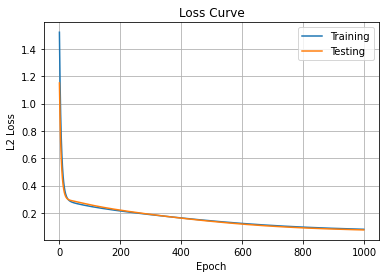

In [941]:
Del2_MLP = MLP(3,[2,1,1], ['ReLU','linear'], 'L2')
opt = BGD(Del2_MLP)
Train_loss, Test_loss = train(Del2_MLP, x_train, y_train, x_test, y_test, opt, epoch = 1000, loss_fun='L2', lr=0.0001)

plt.title('Loss Curve')
plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.plot(Train_loss, label="Training")
plt.plot(Test_loss, label="Testing")
plt.legend()
plt.ylabel('L2 Loss')
plt.xlabel('Epoch')

print('Training and Testing Losses, respectively: ', Train_loss[-1], Test_loss[-1])

(400, 1)
Z1 shape:  (54056, 1)
XX,yy:  (232, 233) (232, 233)
Z2:  (232, 233)


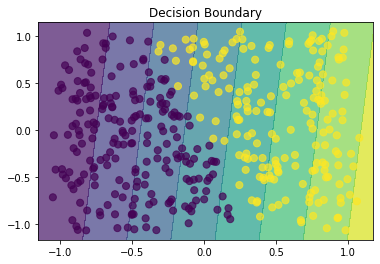

In [942]:
plt.title('Decision Boundary')
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
print(Y.shape)
plot_decision_boundary(X, Y, Del2_MLP,boundry_level=None)

# XOR Dataset

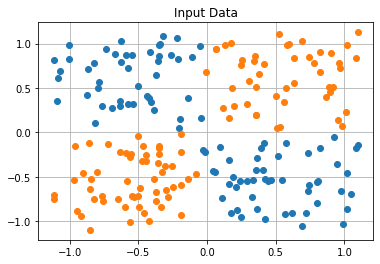

In [968]:
x_train, y_train, x_test, y_test = sample_data(data_name='XOR', nTrain=200, nTest=200, random_seed=0)

class_0 = np.where(y_train == 0)
class_1 = np.where(y_train == 1)

x_train_0 = x_train[class_0[0], :]
x_train_1 = x_train[class_1[0], :]
y_train_0 = np.where(y_train == 0)
y_train_1 = np.where(y_train == 1)

plt.grid()
plt.title('Input Data')
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.scatter(x_train_0[:,0], x_train_0[:,1], label='0')
plt.scatter(x_train_1[:,0], x_train_1[:,1], label='1')
plt.show() # show plot

Training and Testing Losses, respectively:  0.05780095524531861 0.0682309970475029


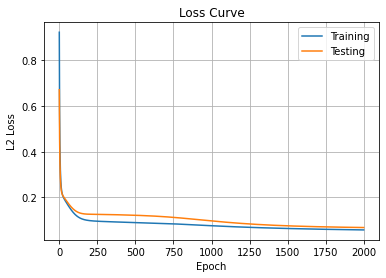

In [944]:
Del3_MLP = MLP(3,[2,4,1], ['tanh','linear'], 'L2')
opt = BGD(Del3_MLP)
Train_loss, Test_loss = train(Del3_MLP, x_train, y_train, x_test, y_test, opt, epoch = 2000, loss_fun='L2', lr=0.001)

plt.title('Loss Curve')
plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.plot(Train_loss, label="Training")
plt.plot(Test_loss, label="Testing")
plt.legend()
plt.ylabel('L2 Loss') 
plt.xlabel('Epoch') 

print('Training and Testing Losses, respectively: ', Train_loss[-1], Test_loss[-1])

Z1 shape:  (58806, 1)
XX,yy:  (243, 242) (243, 242)
Z2:  (243, 242)


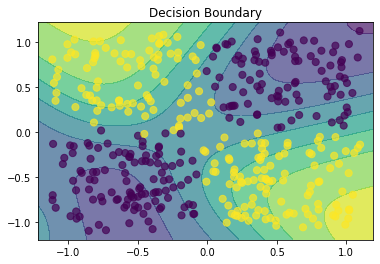

In [945]:
plt.title('Decision Boundary')
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
plot_decision_boundary(X, Y, Del3_MLP,boundry_level=None)

# Differences in cost function and Circle Dataset

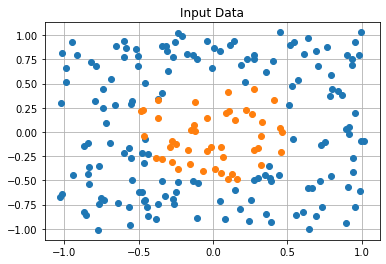

In [969]:
x_train, y_train, x_test, y_test = sample_data(data_name='circle', nTrain=200, nTest=200, random_seed=0)

class_0 = np.where(y_train == 0)
class_1 = np.where(y_train == 1)

x_train_0 = x_train[class_0[0], :]
x_train_1 = x_train[class_1[0], :]
y_train_0 = np.where(y_train == 0)
y_train_1 = np.where(y_train == 1)

plt.grid()
plt.title('Input Data')
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.scatter(x_train_0[:,0], x_train_0[:,1], label='0')
plt.scatter(x_train_1[:,0], x_train_1[:,1], label='1')
plt.show() # show plot

### L2 loss

Training and Testing Losses, respectively:  0.0644220476738418 0.06479348977660057


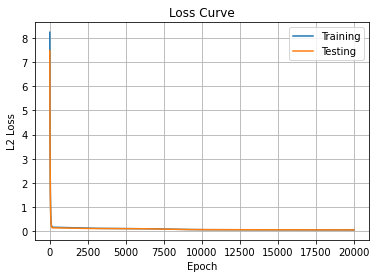

In [947]:
Del4_MLP = MLP(4,[2,4,4,1], ['ReLU', 'ReLU','linear'], 'L2')
opt = BGD(Del4_MLP)
Train_loss, Test_loss = train(Del4_MLP, x_train, y_train, x_test, y_test, opt, epoch = 20000, loss_fun='L2', lr=0.0001)

plt.title('Loss Curve')
plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.plot(Train_loss, label="Training")
plt.plot(Test_loss, label="Testing")
plt.legend()
plt.ylabel('L2 Loss') 
plt.xlabel('Epoch') 

print('Training and Testing Losses, respectively: ', Train_loss[-1], Test_loss[-1])

Z1 shape:  (50625, 1)
XX,yy:  (225, 225) (225, 225)
Z2:  (225, 225)


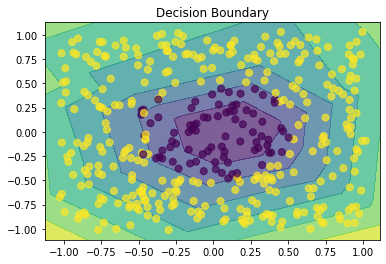

In [948]:
plt.title('Decision Boundary')
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
plot_decision_boundary(X, Y, Del4_MLP,boundry_level=None)

### Cross entropy

Training and Testing Losses, respectively:  0.05301075371588494 0.09598772615005365


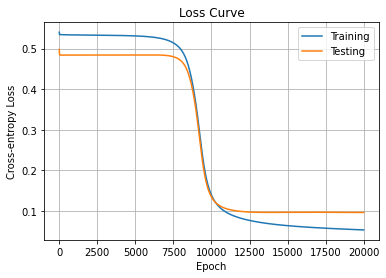

In [949]:
Del4_MLP = MLP(4,[2,4,4,1], ['sigmoid', 'sigmoid','sigmoid'], 'cross_entropy')
opt = BGD(Del4_MLP)
Train_loss, Test_loss = train(Del4_MLP, x_train, y_train, x_test, y_test, opt, epoch = 20000, loss_fun='cross_entropy', lr=0.001)

plt.title('Loss Curve')
plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.plot(Train_loss, label="Training")
plt.plot(Test_loss, label="Testing")
plt.legend()
plt.ylabel('Cross-entropy Loss') 
plt.xlabel('Epoch') 

print('Training and Testing Losses, respectively: ', Train_loss[-1], Test_loss[-1])

Z1 shape:  (50625, 1)
XX,yy:  (225, 225) (225, 225)
Z2:  (225, 225)


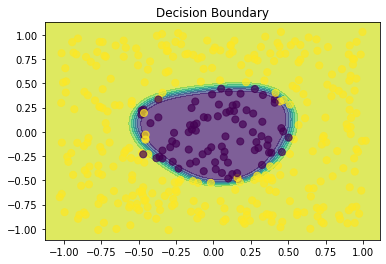

In [950]:
plt.title('Decision Boundary')
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
plot_decision_boundary(X, Y, Del4_MLP,boundry_level=None)

# Deliverable 5

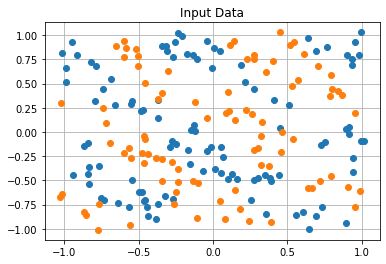

In [976]:
x_train, y_train, x_test, y_test = sample_data(data_name='sinusoid', nTrain=200, nTest=200, random_seed=0)

class_0 = np.where(y_train == 0)
class_1 = np.where(y_train == 1)

x_train_0 = x_train[class_0[0], :]
x_train_1 = x_train[class_1[0], :]
y_train_0 = np.where(y_train == 0)
y_train_1 = np.where(y_train == 1)

plt.grid()
plt.title('Input Data')
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.scatter(x_train_0[:,0], x_train_0[:,1], label='0')
plt.scatter(x_train_1[:,0], x_train_1[:,1], label='1')
plt.show() # show plot

### Basic Gradient Descent

Training and Testing Losses, respectively:  0.6011753156562518 0.6903326204412054
Z1 shape:  (50625, 1)
XX,yy:  (225, 225) (225, 225)
Z2:  (225, 225)


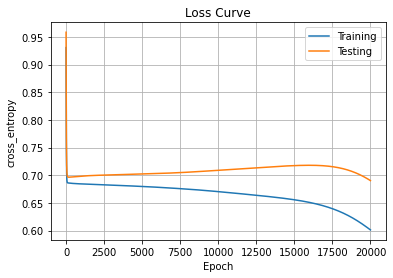

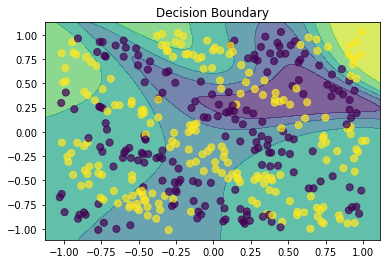

In [973]:
Del5_MLP = MLP(5,[2,5,5,5,1], ['tanh','tanh','tanh','sigmoid'], 'cross_entropy')
opt = BGD(Del5_MLP)
Train_loss, Test_loss = train(Del5_MLP, x_train, y_train, x_test, y_test, opt, epoch = 20000, loss_fun='cross_entropy', lr=0.0001)

plt.title('Loss Curve')
plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.plot(Train_loss, label="Training")
plt.plot(Test_loss, label="Testing")
plt.legend()
plt.ylabel('cross_entropy') 
plt.xlabel('Epoch') 

print('Training and Testing Losses, respectively: ', Train_loss[-1], Test_loss[-1])

plt.figure()
plt.title('Decision Boundary')
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
plot_decision_boundary(X, Y, Del5_MLP,boundry_level=None)

### Gradient Descent with momentum

Training and Testing Losses, respectively:  0.09434217706415851 0.6602067937566042
Z1 shape:  (50625, 1)
XX,yy:  (225, 225) (225, 225)
Z2:  (225, 225)


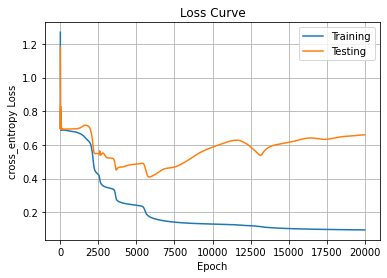

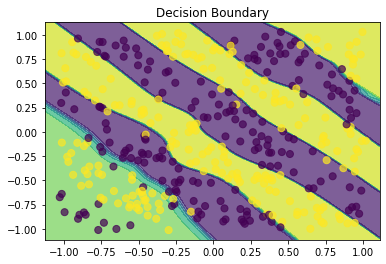

In [974]:
Del5_MLP = MLP(5,[2,5,5,5,1], ['tanh','tanh','tanh','sigmoid'], 'cross_entropy')
opt = GDM(Del5_MLP, 0.95)
Train_loss, Test_loss = train(Del5_MLP, x_train, y_train, x_test, y_test, opt, epoch = 20000, loss_fun='cross_entropy', lr=0.0001)

plt.title('Loss Curve')
plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.plot(Train_loss, label="Training")
plt.plot(Test_loss, label="Testing")
plt.legend()
plt.ylabel('cross_entropy Loss')
plt.xlabel('Epoch')

print('Training and Testing Losses, respectively: ', Train_loss[-1], Test_loss[-1])

plt.figure()
plt.title('Decision Boundary')
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
plot_decision_boundary(X, Y, Del5_MLP,boundry_level=None)

### Adam

Training and Testing Losses, respectively:  0.02162605165711235 0.9550763128829115
Z1 shape:  (50625, 1)
XX,yy:  (225, 225) (225, 225)
Z2:  (225, 225)


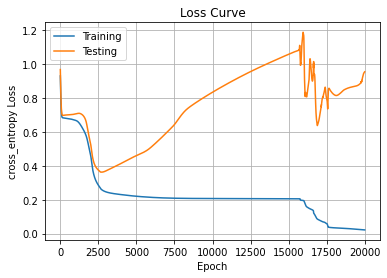

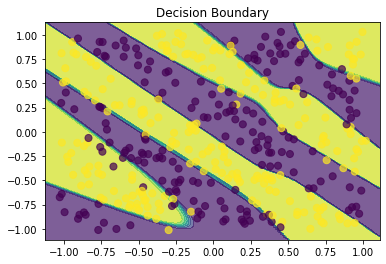

In [977]:
Del5_MLP = MLP(5,[2,5,5,5,1], ['tanh','tanh','tanh','sigmoid'], 'cross_entropy')
opt = Adam(Del5_MLP)
Train_loss, Test_loss = train(Del5_MLP, x_train, y_train, x_test, y_test, opt, epoch = 20000, loss_fun='cross_entropy', lr=0.0001)

plt.title('Loss Curve')
plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.plot(Train_loss, label="Training")
plt.plot(Test_loss, label="Testing")
plt.legend()
plt.ylabel('cross_entropy Loss') 
plt.xlabel('Epoch') 

print('Training and Testing Losses, respectively: ', Train_loss[-1], Test_loss[-1])

plt.figure()
plt.title('Decision Boundary')
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
plot_decision_boundary(X, Y, Del5_MLP,boundry_level=None)

# Deliverable #6

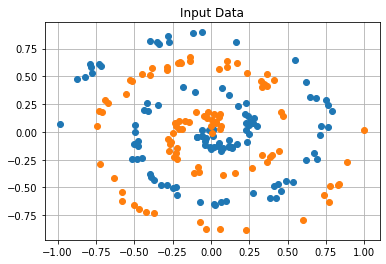

In [978]:
x_train, y_train, x_test, y_test = sample_data(data_name='swiss-roll', nTrain=200, nTest=200, random_seed=0)

class_0 = np.where(y_train == 0)
class_1 = np.where(y_train == 1)

x_train_0 = x_train[class_0[0], :]
x_train_1 = x_train[class_1[0], :]
y_train_0 = np.where(y_train == 0)
y_train_1 = np.where(y_train == 1)


plt.grid()
plt.title('Input Data')
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.scatter(x_train_0[:,0], x_train_0[:,1], label='0')
plt.scatter(x_train_1[:,0], x_train_1[:,1], label='1')
plt.show() # show plot

Training and Testing Losses, respectively:  0.2385009155274426 0.2472490984363012


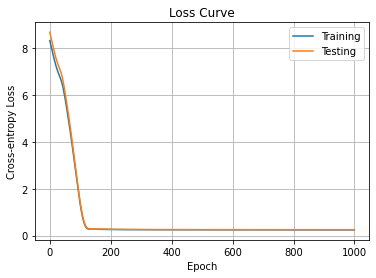

In [956]:
Del6_MLP = MLP(7,[2,10,10,10,10,10,1], ['ReLU','ReLU','ReLU','ReLU','ReLU','linear'], 'L2') 
opt = Adam(Del6_MLP)
Train_loss, Test_loss = train(Del6_MLP, x_train, y_train, x_test, y_test, opt, epoch = 1000, loss_fun='L2', lr=0.00001)

plt.title('Loss Curve')
plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.plot(Train_loss, label="Training")
plt.plot(Test_loss, label="Testing")
plt.legend()
plt.ylabel('Cross-entropy Loss') 
plt.xlabel('Epoch') 

print('Training and Testing Losses, respectively: ', Train_loss[-1], Test_loss[-1])

Z1 shape:  (44676, 1)
XX,yy:  (204, 219) (204, 219)
Z2:  (204, 219)


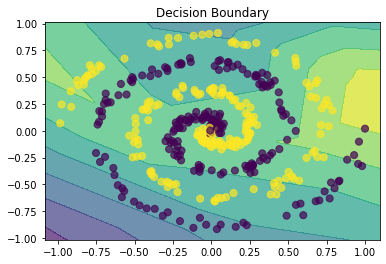

In [957]:
plt.title('Decision Boundary')
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
plot_decision_boundary(X, Y, Del6_MLP,boundry_level=None)

# Deliverable 7

### XOR

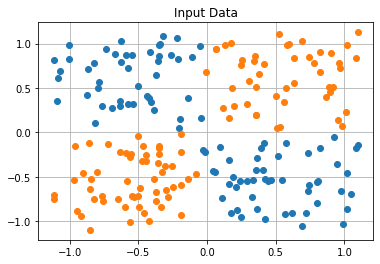

In [979]:
x_train, y_train, x_test, y_test = sample_data(data_name='XOR', nTrain=200, nTest=200, random_seed=0)

class_0 = np.where(y_train == 0)
class_1 = np.where(y_train == 1)

x_train_0 = x_train[class_0[0], :]
x_train_1 = x_train[class_1[0], :]
y_train_0 = np.where(y_train == 0)
y_train_1 = np.where(y_train == 1)


plt.grid()
plt.title('Input Data')
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.scatter(x_train_0[:,0], x_train_0[:,1], label='0')
plt.scatter(x_train_1[:,0], x_train_1[:,1], label='1')
plt.show() # show plot

In [980]:
# new embeddings
# train
x_train_new = x_train
row_products = np.prod(x_train_new, axis=1)
row_products = row_products.reshape((-1, 1))
x_train = np.concatenate((x_train_new, row_products), axis=1)

# test
x_test_new = x_test
row_products = np.prod(x_test_new, axis=1)
row_products = row_products.reshape((-1, 1))
x_test = np.concatenate((x_test_new, row_products), axis=1)

Training and Testing Losses, respectively:  0.03405956627002997 0.05061691426582419


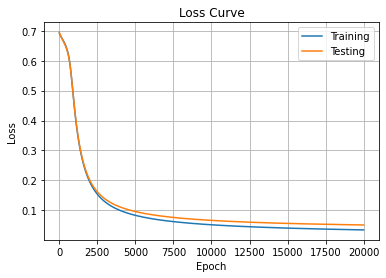

In [988]:
Del7_MLP = MLP(3,[3,1,1], ['tanh','sigmoid'], 'cross_entropy')
opt = BGD(Del7_MLP)
Train_loss, Test_loss = train(Del7_MLP, x_train, y_train, x_test, y_test, opt, epoch = 20000, loss_fun='cross_entropy', lr=0.0001)

plt.title('Loss Curve')
plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.plot(Train_loss, label="Training")
plt.plot(Test_loss, label="Testing")
plt.legend()
plt.ylabel('Loss') 
plt.xlabel('Epoch') 

print('Training and Testing Losses, respectively: ', Train_loss[-1], Test_loss[-1])

In [989]:
def plot_decision_boundary_part7_XOR(X, y, pred_fn, boundry_level=None):
    """
    Plots the decision boundary for the model prediction
    :param X: input data
    :param y: true labels
    :param pred_fn: prediction function,  which use the current model to predict。. i.e. y_pred = pred_fn(X)
    :boundry_level: Determines the number and positions of the contour lines / regions.
    :return:
    """
    
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = pred_fn.forward(np.c_[xx.ravel(), yy.ravel(), yy.ravel()*xx.ravel()])
  
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.7, levels=boundry_level, cmap='viridis_r')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), alpha=0.7,s=50, cmap='viridis_r',)

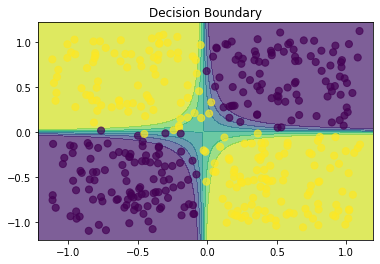

In [990]:
plt.title('Decision Boundary')
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
plot_decision_boundary_part7_XOR(X[:,0:2], Y, Del7_MLP,boundry_level=None)

# Swiss-roll

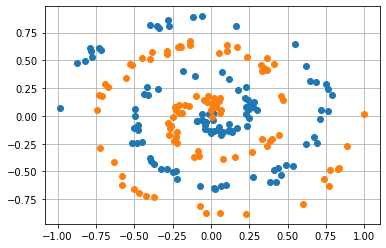

In [992]:
x_train, y_train, x_test, y_test = sample_data(data_name='swiss-roll', nTrain=200, nTest=200, random_seed=0)

class_0 = np.where(y_train == 0)
class_1 = np.where(y_train == 1)

x_train_0 = x_train[class_0[0], :]
x_train_1 = x_train[class_1[0], :]
y_train_0 = np.where(y_train == 0)
y_train_1 = np.where(y_train == 1)


plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.scatter(x_train_0[:,0], x_train_0[:,1], label='0')
plt.scatter(x_train_1[:,0], x_train_1[:,1], label='1')
plt.show() # show plot

In [993]:
# new embeddings
# train

x_train_new = np.sin(x_train)
x_train = np.concatenate((x_train, x_train_new), axis=1)
# test
x_test_new = np.sin(x_test)
x_test = np.concatenate((x_test, x_test_new), axis=1)

Training and Testing Losses, respectively:  0.0077158926821620875 0.04490218316502988


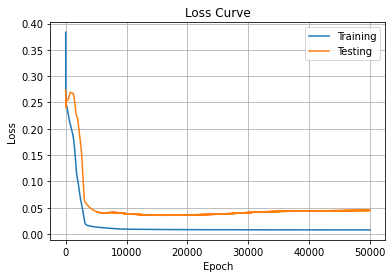

In [1023]:
Del7_MLP = MLP(4,[4,10,10,1], ['tanh', 'tanh','linear'], 'L2') #'sigmoid'
opt = Adam(Del7_MLP)
Train_loss, Test_loss = train(Del7_MLP, x_train, y_train, x_test, y_test, opt, epoch = 50000, loss_fun='L2', lr=0.00001)

plt.title('Loss Curve')
plt.grid()
plt.rcParams['axes.axisbelow'] = True # get the grid behind data point
plt.plot(Train_loss, label="Training")
plt.plot(Test_loss, label="Testing")
plt.legend()
plt.ylabel('Loss') 
plt.xlabel('Epoch') 

print('Training and Testing Losses, respectively: ', Train_loss[-1], Test_loss[-1])

In [1024]:
def plot_decision_boundary_part7_swiss(X, y, pred_fn, boundry_level=None):
    """
    Plots the decision boundary for the model prediction
    :param X: input data
    :param y: true labels
    :param pred_fn: prediction function,  which use the current model to predict。. i.e. y_pred = pred_fn(X)
    :boundry_level: Determines the number and positions of the contour lines / regions.
    :return:
    """
    
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = pred_fn.forward(np.c_[xx.ravel(), yy.ravel(), np.sin(xx.ravel()), np.sin(yy.ravel())])
  
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.7, levels=boundry_level, cmap='viridis_r')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), alpha=0.7,s=50, cmap='viridis_r',)

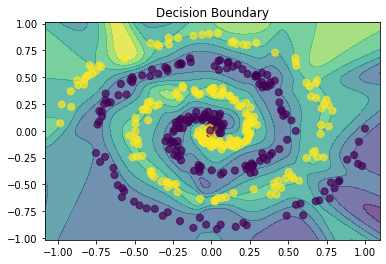

In [1025]:
plt.title('Decision Boundary')
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
plot_decision_boundary_part7_swiss(X, Y, Del7_MLP,boundry_level=None)